<a href="https://colab.research.google.com/github/Dioriza/Tensorflow-Project/blob/master/ImageClassification_225class_save_TF_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Common Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get Dataset from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"muhammaddioriza","key":"9659fcadd4165a4b3a9c1a4820340a31"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!pip install -q kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
local_zip = '/content/100-bird-species.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Show Dataset

#### Data set of 225 bird species. **31316 training images, 1125 test images(5 per species)**. All images are 224 X 224 X 3 color images in jpg format. Also includes a "consolidated" image set that combines the training, test and validation images into a single data set. This is useful for users that want to create their own training, test and validation sets. Each set contains 225 sub directories, one for each bird species.Images for each species are contained in a separate sub directory.

In [ ]:
def show_train_img(category):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    train_path = '/tmp/train'
    ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(train_path, category, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

AFRICAN FIREFINCH


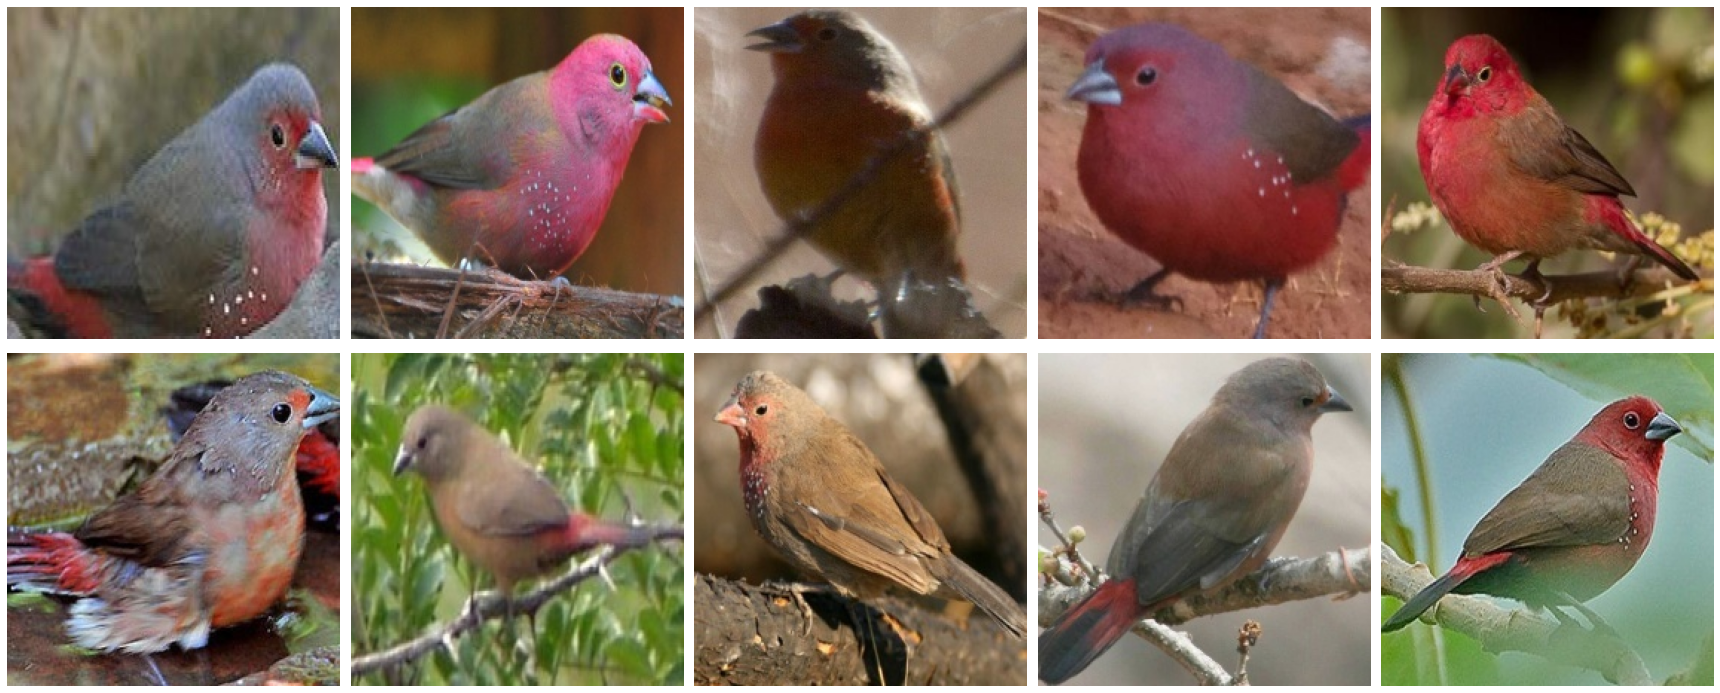

In [ ]:
show_train_img('AFRICAN FIREFINCH')
print('AFRICAN FIREFINCH')

BLACK SWAN


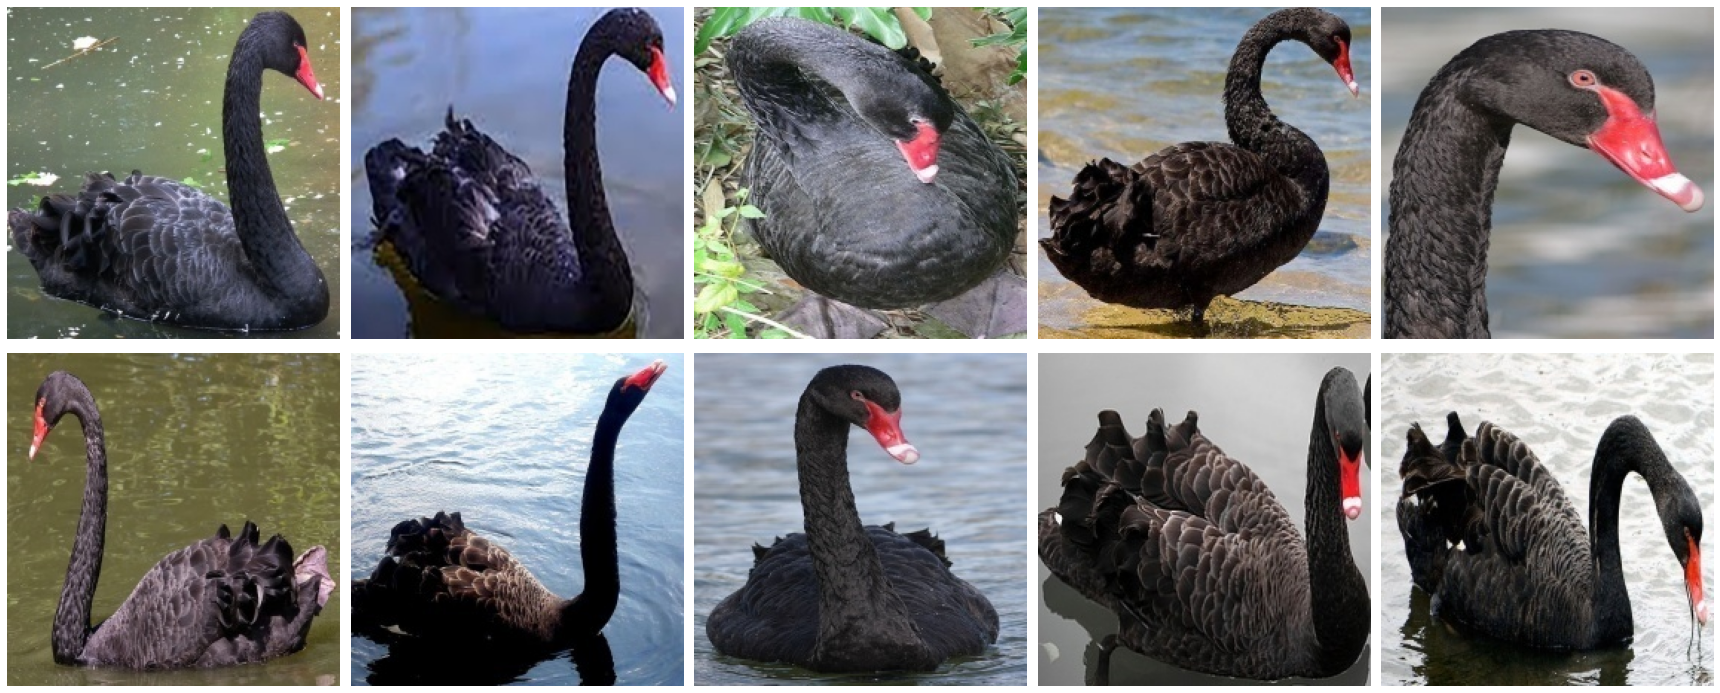

In [ ]:
show_train_img('BLACK SWAN')
print('BLACK SWAN')

INDIAN BUSTARD


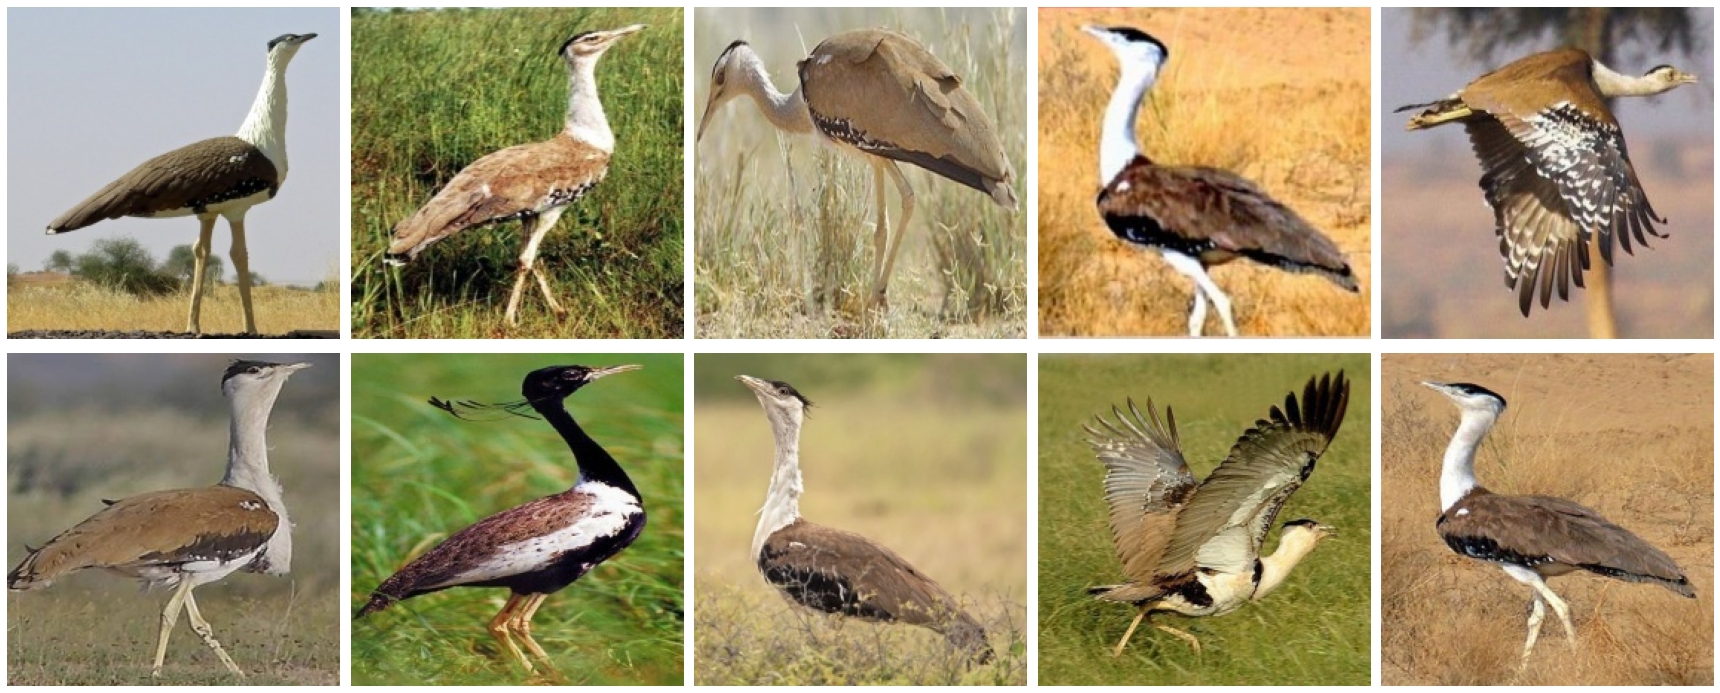

In [ ]:
show_train_img('INDIAN BUSTARD')
print('INDIAN BUSTARD')

## Data Preprocessing

In [ ]:
#Parameters
epochs = 15
batch_size = 64
learning_rate = 0.001
size_image = 229
checkpoint_path = "train_ckpt/cp.ckpt"

In [ ]:
data_dir = '/tmp/train'


train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.15,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    validation_split=0.2
                    )
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.15,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    validation_split=0.2
                    )

In [ ]:
train_gen = train_datagen.flow_from_directory(
                                          data_dir,
                                          target_size = (size_image, size_image),
                                          batch_size=batch_size,
                                          class_mode = 'categorical',
                                          subset='training'
                                          )

test_gen = test_datagen.flow_from_directory(
                                          data_dir,
                                          target_size=(size_image, size_image),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset='validation'
                                          )

Found 25139 images belonging to 225 classes.
Found 6177 images belonging to 225 classes.


# Data Modelling using Transfer Learning

## Architecture InceptionResNetV2

![alt text](https://www.researchgate.net/profile/Masoud_Mahdianpari/publication/326421398/figure/fig9/AS:649354851385344@1531829669740/Schematic-diagram-of-InceptionResNetV2-model-compressed-view.png)

---

## Benchmarks Architecture InceptionResNetV2
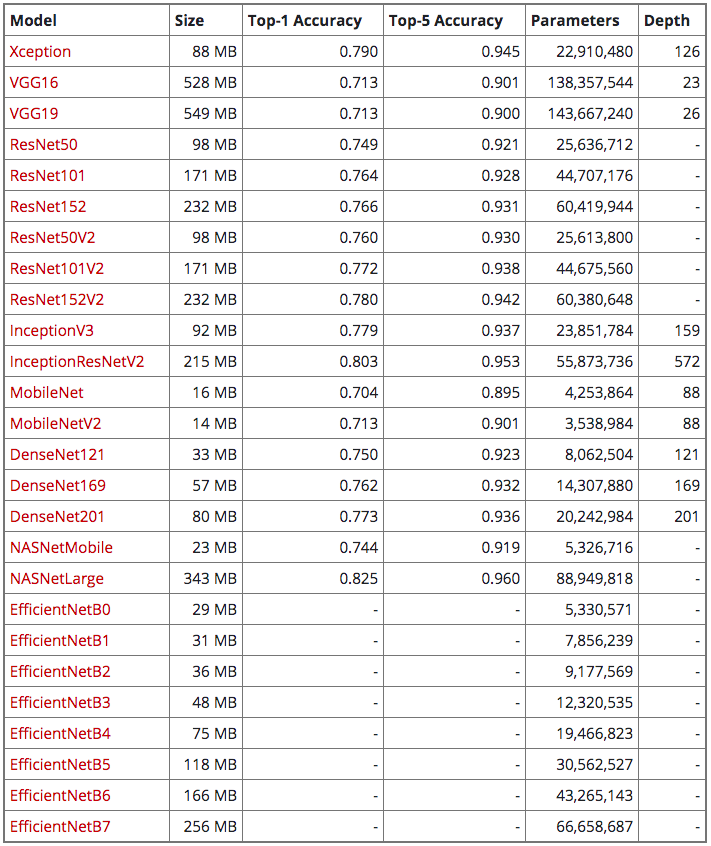


In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
def create_model():
  model = tf.keras.Sequential([
         InceptionResNetV2(
             include_top=False,
             weights="imagenet",
             input_shape=(size_image, size_image, 3),
        ),
        # add additional layer in the end of inceptionResNetV2 layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1025, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(225, activation='softmax')
    ])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
  return model

# Create a basic model instance
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 1025)              39361025  
_________________________________________________________________
dropout (Dropout)            (None, 1025)              0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 1025)              4100      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [ ]:
#Set 3 Callback. Learning rate, Early Stopping and Model Checkpoint
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True, 
                                                 save_weights_only=True,
                                                 verbose=1)

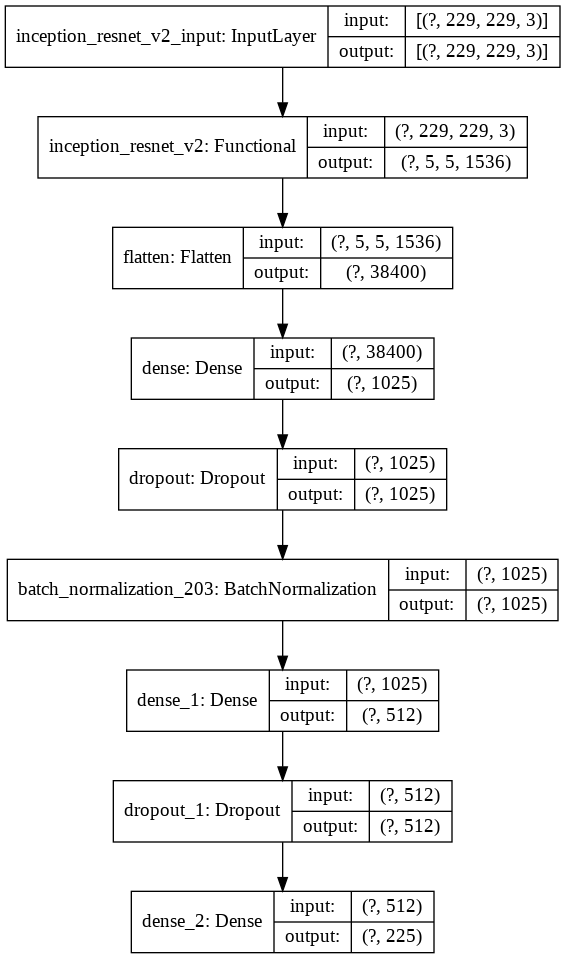

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training

In [ ]:
history = model.fit(
                    train_gen,
                    validation_data=test_gen,
                    epochs=epochs,
                    callbacks=[early_stopper, reduce_lr, cp_callback],
                    steps_per_epoch= train_gen.samples / train_gen.batch_size -1
                    )

model.save('submissionTFlite.h5')

Epoch 1/15
392/391 [==============================] - ETA: 0s - loss: 5.0586 - accuracy: 0.0346
Epoch 00001: val_loss improved from inf to 4.43457, saving model to train_ckpt/cp.ckpt
392/391 [==============================] - 445s 1s/step - loss: 5.0586 - accuracy: 0.0346 - val_loss: 4.4346 - val_accuracy: 0.0696
Epoch 2/15
392/391 [==============================] - ETA: 0s - loss: 3.5133 - accuracy: 0.1858
Epoch 00002: val_loss did not improve from 4.43457
392/391 [==============================] - 433s 1s/step - loss: 3.5133 - accuracy: 0.1858 - val_loss: 8.4904 - val_accuracy: 0.2121
Epoch 3/15
392/391 [==============================] - ETA: 0s - loss: 2.6534 - accuracy: 0.3414
Epoch 00003: val_loss improved from 4.43457 to 4.19264, saving model to train_ckpt/cp.ckpt
392/391 [==============================] - 439s 1s/step - loss: 2.6534 - accuracy: 0.3414 - val_loss: 4.1926 - val_accuracy: 0.4156
Epoch 4/15
392/391 [==============================] - ETA: 0s - loss: 1.9558 - accuracy

# Training Plotting

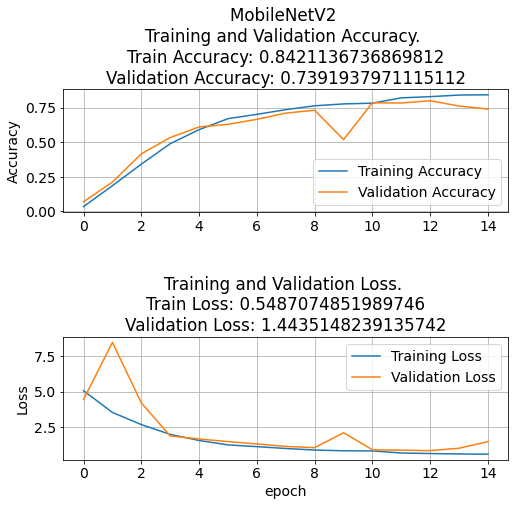

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'InceptionResNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

# Re-Training from Last Model Checkpoint

In [ ]:
model_ckpt2 = create_model()

model_ckpt2.load_weights('train_ckpt/cp.ckpt')


In [ ]:
loss,acc = model_ckpt2.evaluate(test_gen, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

97/97 - 70s - loss: 0.7922 - accuracy: 0.8007
Restored model, accuracy: 80.07%


In [ ]:
history_checkpoint = model_ckpt2.fit(
                    train_gen,
                    validation_data=test_gen,
                    batch_size=128,
                    epochs=10,
                    callbacks=[early_stopper, reduce_lr, cp_callback],
                    steps_per_epoch= train_gen.samples / train_gen.batch_size -1
                    )

model.save('submissionTFlite2.h5')

Epoch 1/10
392/391 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.8444
Epoch 00001: val_loss improved from 0.80181 to 0.75019, saving model to train_ckpt/cp.ckpt
392/391 [==============================] - 439s 1s/step - loss: 0.5311 - accuracy: 0.8444 - val_loss: 0.7502 - val_accuracy: 0.8088
Epoch 2/10
392/391 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.8522
Epoch 00002: val_loss did not improve from 0.75019
392/391 [==============================] - 436s 1s/step - loss: 0.5123 - accuracy: 0.8522 - val_loss: 0.8047 - val_accuracy: 0.7920
Epoch 3/10
392/391 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8573
Epoch 00003: val_loss did not improve from 0.75019
392/391 [==============================] - 435s 1s/step - loss: 0.4926 - accuracy: 0.8573 - val_loss: 0.8176 - val_accuracy: 0.7978
Epoch 4/10
392/391 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.8615
Epoch 00004: ReduceLROnPlat

# Re-Training Plot

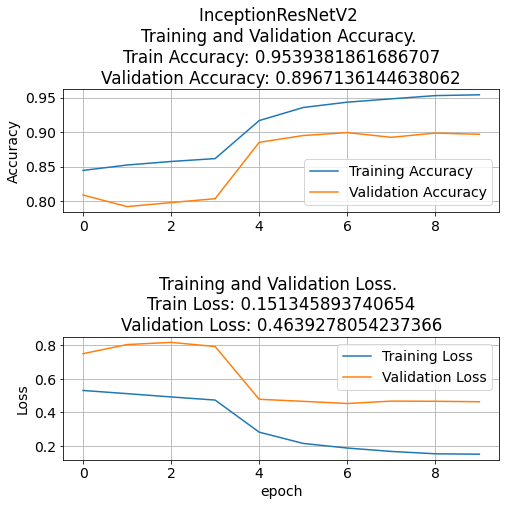

In [ ]:
#plot results
acc = history_checkpoint.history['accuracy']
val_acc = history_checkpoint.history['val_accuracy']
loss = history_checkpoint.history['loss']
val_loss = history_checkpoint.history['val_loss']

#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'InceptionResNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

# Validation Score

In [ ]:
model_ckpt2 = create_model()

model_ckpt2.load_weights('train_ckpt/cp.ckpt')

loss,acc = model_ckpt2.evaluate(test_gen, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

97/97 - 71s - loss: 0.4358 - accuracy: 0.9003
Restored model, accuracy: 90.03%


# Convert Model to Tensorflow Lite

In [ ]:
# Konversi model
converter = tf.lite.TFLiteConverter.from_keras_model(model_ckpt2)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model_bird_species_MobilenetV2.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmppn31yrud/assets


# Resources


1.   https://www.dicoding.com/academies/185/tutorials/10239
2.   https://www.kaggle.com/chekoduadarsh/inceptionresnetv2-tpu-vs-gpu-benchmark#For-GPU-go-to-the-following-link-[Under-Edit]
3. https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models
4. https://www.kaggle.com/rimbax/product-detection-with-mobilenetv2-tensorflow
5. https://www.kaggle.com/abdilatifssou/sample-use-of-efficientnetb7-achieved-97-8
6. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
7. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
8. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
9. https://www.kaggle.com/gpiosenka/100-bird-species
10. https://www.mathworks.com/help/deeplearning/ref/inceptionresnetv2.html
11. https://medium.com/@zahraelhamraoui1997/inceptionresnetv2-simple-introduction-9a2000edcdb6
12. https://github.com/yuyang-huang/keras-inception-resnet-v2

